# Multi-class Classification

In this notebook, we will train multiple models to fit multiple datasets for multi-class classification. We do this efficiently by defining models and datasets within lists and then looping over those lists to compare results of different models.

* We will look at datasets that are linearly separable (blobs) and are not linearly separable (circles & spirals). 

* We will use Cross Entropy Loss in all cases with softmax to turn logits into probabilities and argmax to turn probabilities into predictions.

* We will apply the same 3-linear-layer NN model to all cases with either no nonlinearities or pointwise nonlinearities after the first and second layers.

## 0. Preliminaries, Imports and Definitions:

In [1]:
# Import statements
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, make_classification, make_gaussian_quantiles
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

from helper_functions import scatter_2D_class, plot_loss, plot_decision_boundary, accuracy_fn
from models import ThreeLayerModel2, train_step_multi_classification, test_step_multi_classification

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Hyperparameters

HID_DIM = 10
NUM_LAYERS = 3
NL_TYPE_list = [None,'relu'] # 'relu', 'sigmoid', 'tanh', None
EPOCHS = 2100
LEARNING_RATE = 0.1

NUM_SAMPLES=1000
NUM_CLASSES = 4
NUM_FEATURES = 2


RANDOM_SEED = 42

verbose = True

In [3]:
# Device agnostic code to be able to run on GPU when available

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

Device is cpu


In [4]:
# Definition 1: Create spirals data that is not linearly separable

def make_spirals(n_samples=1000,
                 n_features=2,
                 n_classes=3):
    
    """ Function that creates spiral dataset that is not linearly separable.
    
    :args:
        :n_samples: - total number of samples
        :n_features: - number of dimensions for input X
        :n_classes: - number of classes for multiclass classification
        
    :returns:
        :X: - features, input to classifier
        :y: - class labels
    
    """
    
    N = int(np.floor(n_samples/n_classes)) # number of points per class
    D = n_features # dimensionality
    K = n_classes # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    
    return X, y

In [5]:
# Definition 2: Evaluate model 

def eval_model(model, 
               loss_count, 
               test_loss_count, 
               acc_count,
               test_acc_count,
               epochs,
               datatype,
               hid_dim,
               nl_type,
               num_layers):
    """
    Return model name, best loss and best test_loss in a dictionary to compare models at the end.
    """

    return {"model_name": model.__class__.__name__,
            "model_nonlin": nl_type,
            "model_layers": num_layers,
            "model_hidden_units": hid_dim,
            "data": datatype,
            "train_loss": loss_count[-1],
            "test_loss": test_loss_count[-1],
            "train_acc": acc_count[-1].item(),
            "test_acc": test_acc_count[-1].item(),
            "epochs": epochs
            }

In [6]:
def tensor_and_split(X: np.ndarray, y:np.ndarray, RANDOM_SEED=42):
    
    """ Convert np.ndarrays for X, y in dataset construction into torch.tensors and split them
        into 80% train and 20% test splits.
        
        :args:
            :X:
            :y:
            
        :returns:
            :X_train: 
            :X_test: 
            :y_train: 
            :y_test:
    """

    # Turn data into tensors
    X = torch.from_numpy(X).type(torch.float32)    # float32 decimal digit
    y = torch.from_numpy(y).type(torch.ByteTensor) # unsigned 8-bit integer (can also be ByteTensor, ShortTensor, IntTensor, LongTensor)

    # Split data into train & test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_SEED)

    return X_train, X_test, y_train, y_test

## 1. Construct, format, split, package data

In [7]:
# Construct 3 different datasets. Split and package them into a list.

ds = []


# # Dataset 1: Create linearly separable blobs data
if True:
    X, y = make_blobs(n_samples = NUM_SAMPLES,
                      n_features = NUM_FEATURES,
                      centers = NUM_CLASSES,
                      cluster_std = 1.5,
                      random_state = RANDOM_SEED)

    X_train, X_test, y_train, y_test = tensor_and_split(X, y, RANDOM_SEED)

    datatype = f"blobs{NUM_CLASSES}_samples{NUM_SAMPLES}_features{NUM_FEATURES}"

    ds.append([X_train, X_test, y_train, y_test, datatype])


# Dataset 2: Create concentric circles multiclass dataset that is not linearly separable 
if True:
    X, y = make_gaussian_quantiles(n_samples = NUM_SAMPLES,
                            n_features = NUM_FEATURES,
                            n_classes = NUM_CLASSES)

    X_train, X_test, y_train, y_test = tensor_and_split(X, y, RANDOM_SEED)

    datatype = f"circles{NUM_CLASSES}_samples{NUM_SAMPLES}_features{NUM_FEATURES}"

    ds.append([X_train, X_test, y_train, y_test, datatype])


# Dataset 3:  Create spirals multiclass dataset that is not linearly separable
if True:
    X, y = make_spirals(n_samples = NUM_SAMPLES,
                        n_features = NUM_FEATURES,
                        n_classes = NUM_CLASSES)

    X_train, X_test, y_train, y_test = tensor_and_split(X, y, RANDOM_SEED)

    datatype = f"spirals{NUM_CLASSES}_samples{NUM_SAMPLES}_features{NUM_FEATURES}"

    ds.append([X_train, X_test, y_train, y_test, datatype])

In [8]:
# # Print some data shapes:

print(f"Number of datasets: {len(ds)}")
print(f"Number of things in 1st dataset: {len(ds[0])}")
print(f"")
print(f"Name of dataset 1: {ds[0][4]}")
print(f"Name of dataset 2: {ds[1][4]}")
print(f"Name of dataset 3: {ds[2][4]}")
print(f"")
print(f"Inside dataset 1: ")
print(f"   Element 1 shape: {ds[0][0].shape}")
print(f"   Element 2 shape: {ds[0][1].shape}")
print(f"   Element 3 shape: {ds[0][2].shape}")
print(f"   Element 4 shape: {ds[0][3].shape}")

# X.shape, y.shape, type(X), type(y), X.dtype, y.dtype, X[:3], y[:3]

Number of datasets: 3
Number of things in 1st dataset: 5

Name of dataset 1: blobs4_samples1000_features2
Name of dataset 2: circles4_samples1000_features2
Name of dataset 3: spirals4_samples1000_features2

Inside dataset 1: 
   Element 1 shape: torch.Size([800, 2])
   Element 2 shape: torch.Size([200, 2])
   Element 3 shape: torch.Size([800])
   Element 4 shape: torch.Size([200])


## 2. Visualize data

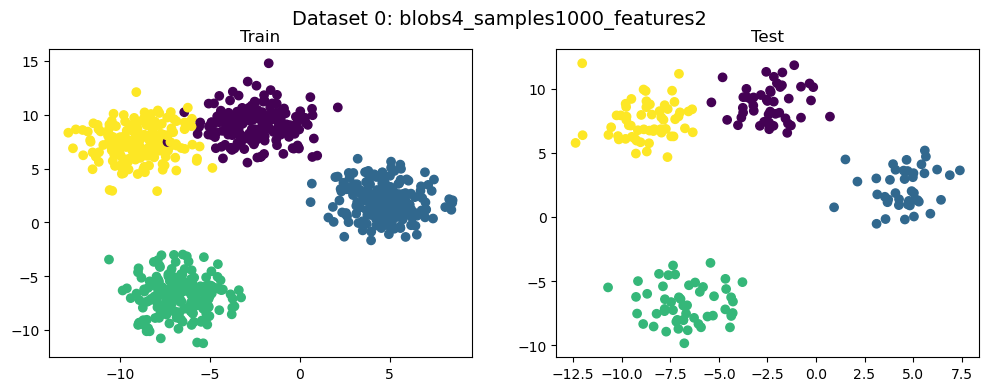

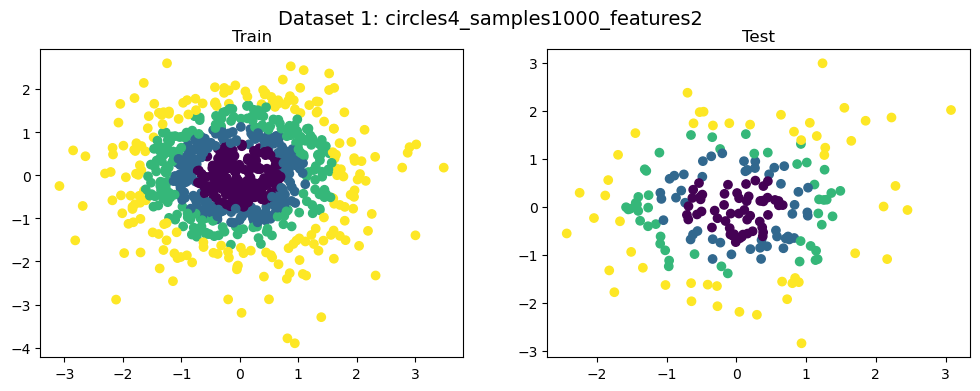

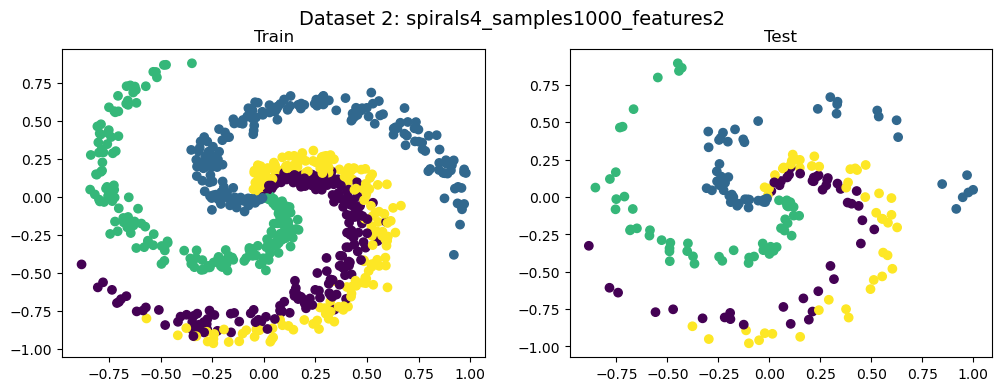

In [9]:
# Unpack data in each dataset and scatter plot it

for i, [X_train, X_test, y_train, y_test, datatype] in enumerate(ds):
    
    # Plot data
    scatter_2D_class(train_data = X_train,
                  train_labels = y_train,
                  test_data = X_test,
                  test_labels = y_test)
    plt.suptitle(f"Dataset {i}: {datatype}", fontsize=14);

## 2. Define Loss Function and Models to train

* Note: Model `ThreeLayerModel2` defined in models.py
* We define optimizer below inside loop over datasets and models because it requires model params as input.

In [10]:
# Create Loss function

loss_fn = nn.CrossEntropyLoss() # Loss function for multi-class classification

In [11]:
# Instantiate 6 models total to train on 3 datasets, one linear and one nonlinear on each dataset.

models = []

for d in range(len(ds)):
    models.append([])
    
    for nl, NL_TYPE in enumerate(NL_TYPE_list):
        
        models[d].append( ThreeLayerModel2(in_dim=NUM_FEATURES,
                              out_dim=NUM_CLASSES,
                              hid_dim=HID_DIM,
                              nl_type=NL_TYPE).to(device) )



In [12]:
len(models), len(models[0])

(3, 2)

## 3. Make predictions with untrained models

In [13]:
for d, [X_train, X_test, y_train, y_test, datatype] in enumerate(ds):
    
    for nl, NL_TYPE in enumerate(NL_TYPE_list):

        model = models[d][nl]

        model.eval()

        with torch.inference_mode():
            y_logits = model(X_test)

        y_prob = torch.softmax(y_logits,dim=1) # convert logits to prediction probabilities
        y_pred = torch.argmax(y_prob,dim=1) # find location of max after softmax

        loss_untrained = loss_fn(y_logits, y_test)

        acc_untrained = accuracy_fn(y_pred, y_test)
        
        print(f"Untrained Model with {NL_TYPE} NL on {datatype} \n      Loss: {loss_untrained.item():.4f} | Accuracy: {acc_untrained.item():.4f}")
    print("\n")

Untrained Model with None NL on blobs4_samples1000_features2 
      Loss: 1.7334 | Accuracy: 0.2750
Untrained Model with relu NL on blobs4_samples1000_features2 
      Loss: 1.6687 | Accuracy: 0.0800


Untrained Model with None NL on circles4_samples1000_features2 
      Loss: 1.4751 | Accuracy: 0.1550
Untrained Model with relu NL on circles4_samples1000_features2 
      Loss: 1.3947 | Accuracy: 0.2450


Untrained Model with None NL on spirals4_samples1000_features2 
      Loss: 1.3717 | Accuracy: 0.3900
Untrained Model with relu NL on spirals4_samples1000_features2 
      Loss: 1.3852 | Accuracy: 0.2600




## 4. Train models

In [14]:
results = [] # empty list to fill with results for each model & dataset combination

# Loop over datasets
for d, [X_train, X_test, y_train, y_test, datatype] in enumerate(ds):
    
    # Loop over nonlinearity types that will make different models
    for nl, NL_TYPE in enumerate(NL_TYPE_list):

        model = models[d][nl] # extract model from models list.

        # Set up seeds for reproducability.
        torch.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed(RANDOM_SEED)

        # define optimizer within loop over models because it takes in model parameters.
        optimizer = torch.optim.SGD(params=model.parameters(), lr=LEARNING_RATE)

        epochs = EPOCHS
        eval_freq = 300

        # Empty lists to collect up performance metrics during training loop
        epoch_count = []
        loss_count = []
        accuracy_count = []
        test_loss_count = []
        test_accuracy_count = []
        
        print(f"\n Dataset: {datatype} - Training model with {NL_TYPE} nonlinearity \n")

        # Loop through all data in training and test datasets once per epoch
        for epoch in range(epochs+1):

            loss, acc = train_step_multi_classification(data = X_train, 
                                                        labels = y_train, 
                                                        model = model, 
                                                        loss_fn = loss_fn, 
                                                        accuracy_fn = accuracy_fn,
                                                        optimizer = optimizer)
            
            # only run test step and collect eval metrics every {eval_freq} epochs
            if epoch % eval_freq == 0:

                test_loss, test_acc = test_step_multi_classification(data = X_test, 
                                                                     labels = y_test, 
                                                                     model = model, 
                                                                     loss_fn = loss_fn,
                                                                     accuracy_fn = accuracy_fn,)

                # collect evaluation metrics into lists
                epoch_count.append(epoch)
                loss_count.append(loss.item())
                accuracy_count.append(acc)
                test_loss_count.append(test_loss.item())
                test_accuracy_count.append(test_acc)

                # Display evaluation metrics
                print(f"Epoch: {epoch:4d} | Loss: {loss:.4f} - Acc: {acc:.3f} | Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.3f}")

                
        # Store results for each model & dataset combination into results list.
        results.append(eval_model(model=model, 
                                 loss_count=loss_count, 
                                 test_loss_count=test_loss_count, 
                                 acc_count=accuracy_count,
                                 test_acc_count=test_accuracy_count,
                                 epochs=EPOCHS,
                                 datatype=datatype,
                                 hid_dim=HID_DIM,
                                 nl_type=NL_TYPE,
                                 num_layers=NUM_LAYERS))


 Dataset: blobs4_samples1000_features2 - Training model with None nonlinearity 

Epoch:    0 | Loss: 1.6801 - Acc: 0.250 | Test Loss: 0.7059 - Test Acc: 0.745
Epoch:  300 | Loss: 0.0275 - Acc: 0.991 | Test Loss: 0.0171 - Test Acc: 0.995
Epoch:  600 | Loss: 0.0257 - Acc: 0.991 | Test Loss: 0.0146 - Test Acc: 0.995
Epoch:  900 | Loss: 0.0247 - Acc: 0.991 | Test Loss: 0.0134 - Test Acc: 0.995
Epoch: 1200 | Loss: 0.0240 - Acc: 0.993 | Test Loss: 0.0126 - Test Acc: 0.995
Epoch: 1500 | Loss: 0.0233 - Acc: 0.993 | Test Loss: 0.0118 - Test Acc: 0.995
Epoch: 1800 | Loss: 0.0227 - Acc: 0.993 | Test Loss: 0.0112 - Test Acc: 0.995
Epoch: 2100 | Loss: 0.0221 - Acc: 0.995 | Test Loss: 0.0107 - Test Acc: 0.995

 Dataset: blobs4_samples1000_features2 - Training model with relu nonlinearity 

Epoch:    0 | Loss: 1.6356 - Acc: 0.108 | Test Loss: 1.3247 - Test Acc: 0.260
Epoch:  300 | Loss: 0.0286 - Acc: 0.990 | Test Loss: 0.0182 - Test Acc: 0.995
Epoch:  600 | Loss: 0.0267 - Acc: 0.990 | Test Loss: 0.0

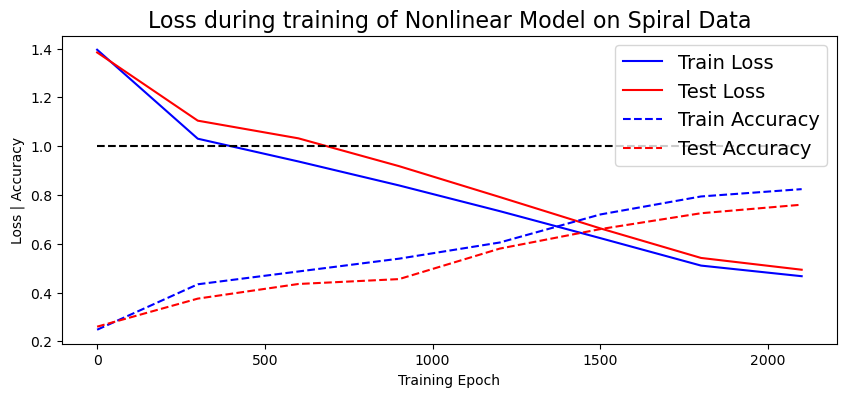

In [28]:
# Plot the loss
if verbose:
    plt.figure(figsize=(10,4))
    plot_loss(epoch = epoch_count,
             loss = loss_count,
             test_loss = test_loss_count,
             acc = accuracy_count,
             test_acc = test_accuracy_count,
             y_scale='linear')
    plt.title(f"Loss during training of Nonlinear Model on Spiral Data",fontsize=16);

Note: The last nonlinear model training on the spirals data seems to be improving still and could benefit from being run for more epochs.

## 5. Visualize Results

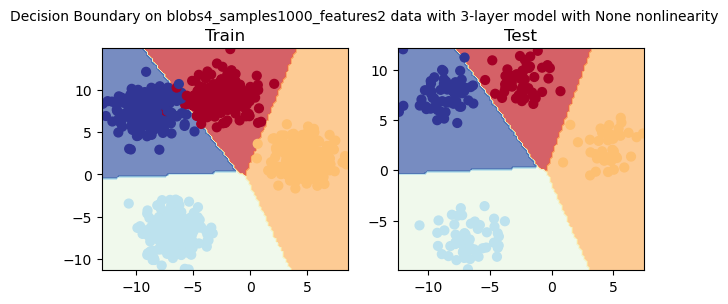

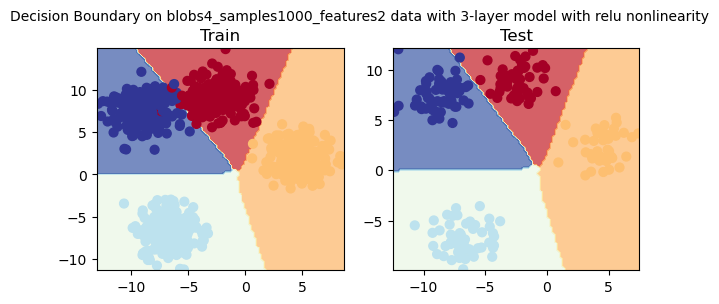

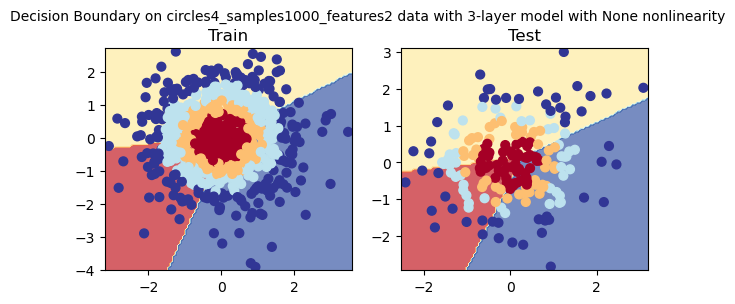

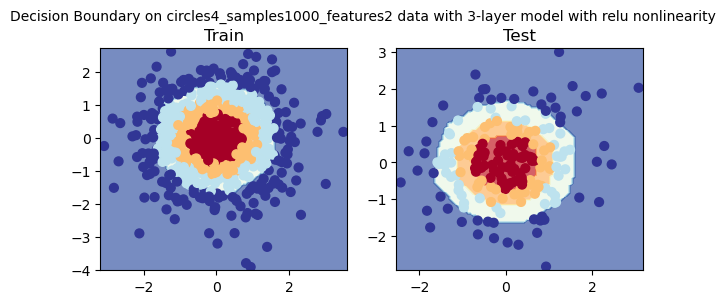

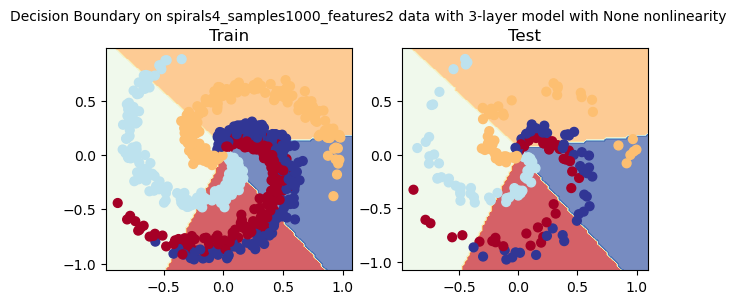

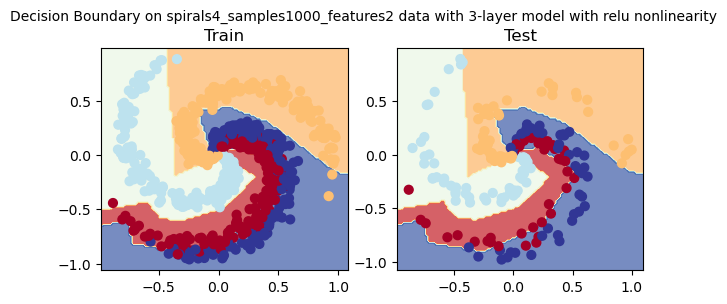

In [26]:
# Plot decision boundaries for each model and datatype combination

for d, [X_train, X_test, y_train, y_test, datatype] in enumerate(ds):
    
    for nl, NL_TYPE in enumerate(NL_TYPE_list):
        
        model = models[d][nl]

        fig = plt.figure(figsize=(7,3))
        plt.subplot(1,2,1)
        plot_decision_boundary(model=model, 
                               X=X_train, 
                               y=y_train)
        plt.title('Train')
        plt.subplot(1,2,2)
        plot_decision_boundary(model=model, 
                               X=X_test, 
                               y=y_test)
        plt.title('Test')
        fig.subplots_adjust(top=0.85)
        plt.suptitle(f'Decision Boundary on {datatype} data with 3-layer model with {NL_TYPE} nonlinearity', fontsize=10);

In [27]:
res = pd.DataFrame(results)
res

,model_name,model_nonlin,model_layers,model_hidden_units,data,train_loss,test_loss,train_acc,test_acc,epochs
0,ThreeLayerModel2,None,3,10,blobs4_samples1000_features2,0.022135,0.010656,0.99500,0.995,2100
1,ThreeLayerModel2,relu,3,10,blobs4_samples1000_features2,0.023069,0.011890,0.99375,0.995,2100
2,ThreeLayerModel2,None,3,10,circles4_samples1000_features2,1.378412,1.390579,0.28750,0.225,2100
3,ThreeLayerModel2,relu,3,10,circles4_samples1000_features2,0.073695,0.084214,0.98250,0.975,2100
4,ThreeLayerModel2,None,3,10,spirals4_samples1000_features2,1.038406,1.130928,0.40125,0.370,2100
5,ThreeLayerModel2,relu,3,10,spirals4_samples1000_features2,0.466877,0.493436,0.82375,0.760,2100


## Conclusion:

We trained a total of 6 models - 2 model types each on 3 different datasets. All models were 3 layers with 10 hidden units in the middle layer. One type of model had no nonlinearities between linear layers and the other type of model had ReLU pointwise nonlinearities after layers 1 and 2. One dataset (blobs) was linearly separable and the other two (circles & spirals) were not. 

The table above compares predictions made from linear and 'relu' nonlinear models trained on these three datasets. Looking at the test accuracy (test_acc) column, both models do well on the linearly separable blobs dataset. The nonlinear model outperforms linear model on the two more complicated datasets. Performance of the nonlinear model on the spirals dataset would improve with more epochs because the training and test loss were still going down at epoch 2100. Decision boundaries for each model and dataset are shown above.